# NaN's in PSF_SIZE output

    Subject: [dsdevel] Bug: Wavdetect produces NaN's in PSF_SIZE output column
    From: Hain, Roger (rhain@cfa.harvard.edu)
    Date: Fri Mar 21 2014 - 14:05:54 EDT


    For the bug tracking system:

    A wavdetect run for L3 testing has produced a value of NaN in the PSF_SIZE
    output column:

    dmlist
    /data/tools/staff/rhain/wavdetect/CAT4.1.5_21MAR2014/output/acisfJ0052448m263517_001N020_b_tmpA_wavsrc3.fits.gz"[cols component,psf_size][#row=108:110]" data
    
    --------------------------------------------------------------------------------
    Data for Table Block SRCLIST
    --------------------------------------------------------------------------------
    
    ROW COMPONENT PSF_SIZE

     1 108 9.6532306671
     2 109 NaN
     3 110 3.4373879433

    Data files are stored in:

    /data/tools/staff/rhain/wavdetect/CAT4.1.5_21MAR2014/output 


Files in this directory have been copied from Roger's directory and uncompressed.

---

## Getting started

In [1]:
source /soft/ciao/bin/ciao.bash -o 

CIAO configuration is complete... 
CIAO 4.9 Friday, December  2, 2016
  bindir      : /soft/ciao-4.9/bin
  CALDB       : 4.7.3


## psfmap to psfmask

Realize, the L3 `psfmap` contains NaN pixel values

In [2]:
dmstat acisfJ0052448m263517_001N020_b_psfmap3.fits cen- sig- med-

acisfJ0052448m263517_001N020_b_psfmap3.fits[arcsec]
    min:	0.30288267136 	      @:	( 4097 4066 )
    max:	22.676017761 	      @:	( 3600 1776 )
   mean:	7.741380924 
    sum:	51417369.58 
   good:	6641886 
   null:	3672979 


The number of `null` pixels (3672979) is the number of NaN valued pixels.

To make visualization easier, we convert the `psfmap` into a `psfmask`.  

In [3]:
dmimgthresh acisfJ0052448m263517_001N020_b_psfmap3.fits - cut=INDEF value=0 | \
dmimgthresh - p0.psfmask cut=:0 value=1 clob+

Pixel values in the psfmask equal to 0 are where the PSFMAP was NaN.  Pixel values in the psfmask equal to 1 are werhe the PSFMAP was greater than 0.

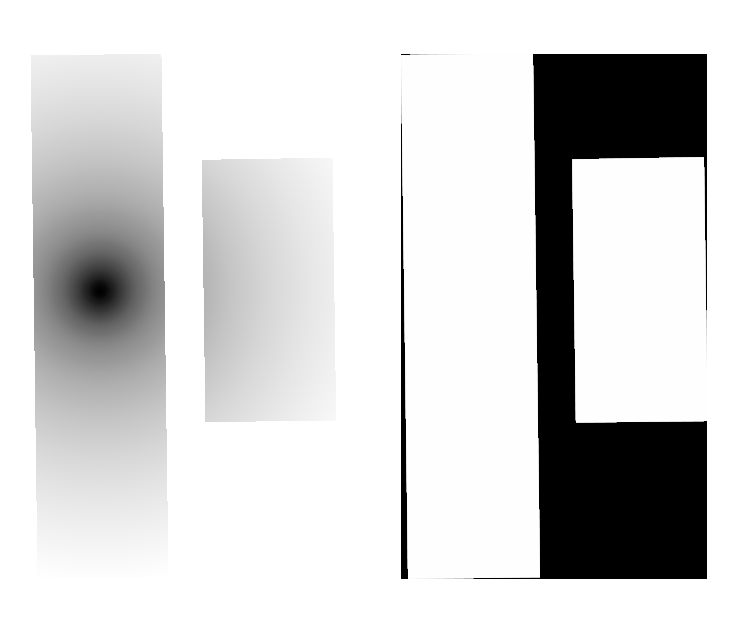

In [4]:
ds9 acisfJ0052448m263517_001N020_b_psfmap3.fits -block 8 -scale log \
  p0.psfmask -view colorbar no -view panner no -view magnifier no -view info no \
  -saveimage png ds9_01.png -quit

display < ds9_01.png

## `expmap` to `expmask`

Similar to the psfmap, we'll create a mask for the exposure map

In [5]:
dmimgthresh acisfJ0052448m263517_001N020_b_exp3.fits e1.expmask cut=:0 value=1 clob+

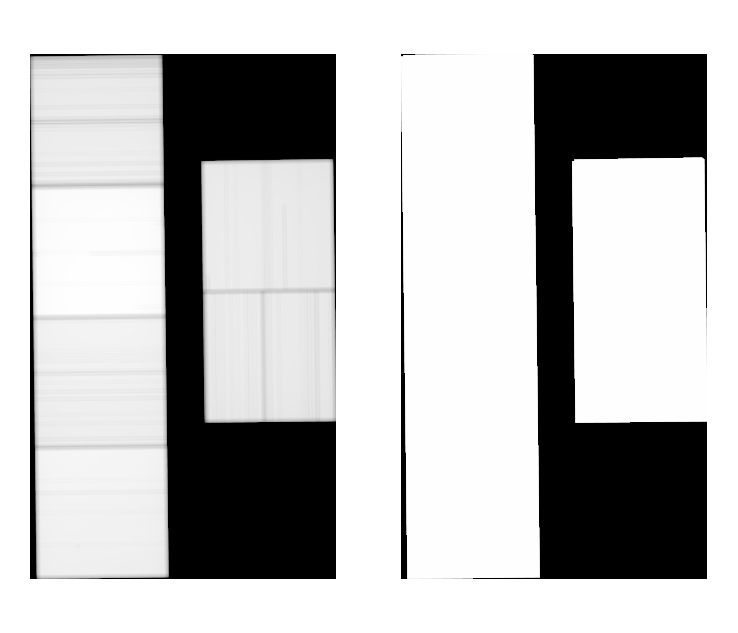

In [6]:
ds9 acisfJ0052448m263517_001N020_b_exp3.fits -block 8 -scale log \
  e1.expmask -view colorbar no -view panner no -view magnifier no -view info no \
  -saveimage png ds9_02.png -quit

display < ds9_02.png

## Are they the same?

Spoiler alert:  no.

In [7]:
dmimgcalc e1.expmask p0.psfmask diff sub clob+

BTIMCORR not present in all input files...FAIL...
BTIMDRFT not present in all input files...FAIL...
BTIMNULL not present in all input files...FAIL...
BTIMRATE not present in all input files...FAIL...


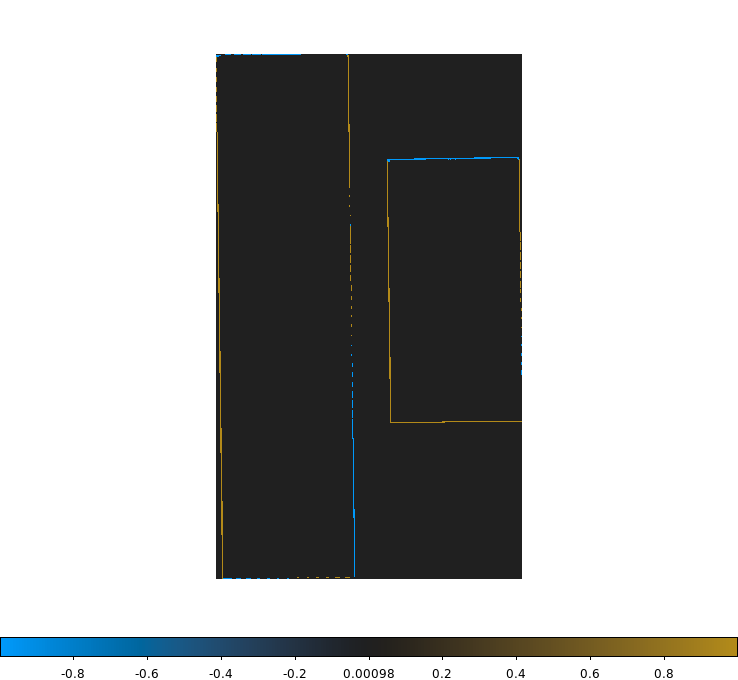

In [8]:
ds9 diff -block 8 -view panner no -view magnifier no -view info no \
  -scale limits -1 1 \
  -cmap load diverging_bky_60-10_c30_n256.lut \
  -saveimage png ds9_03.png -quit

display < ds9_03.png

It's easy to see that the exposure map and the PSF map do not exactly overlap each other.

There region around the edge of the detect where:

- (blue) The exposure map is 0 but the PSF is greather than 0.
- (yellow) The exposure map is not 0, but the PSF is NaN.

We need to zoom into the source region to see what's happening there.

In [9]:
dmlist acisfJ0052448m263517_001N020_b_tmpA_wavsrc3.fits"[component=109][cols x,y,psf_size]" data,clean

#  POS(X,Y)                                 PSF_SIZE
      5872.7240259740      4408.2987012987                  NaN


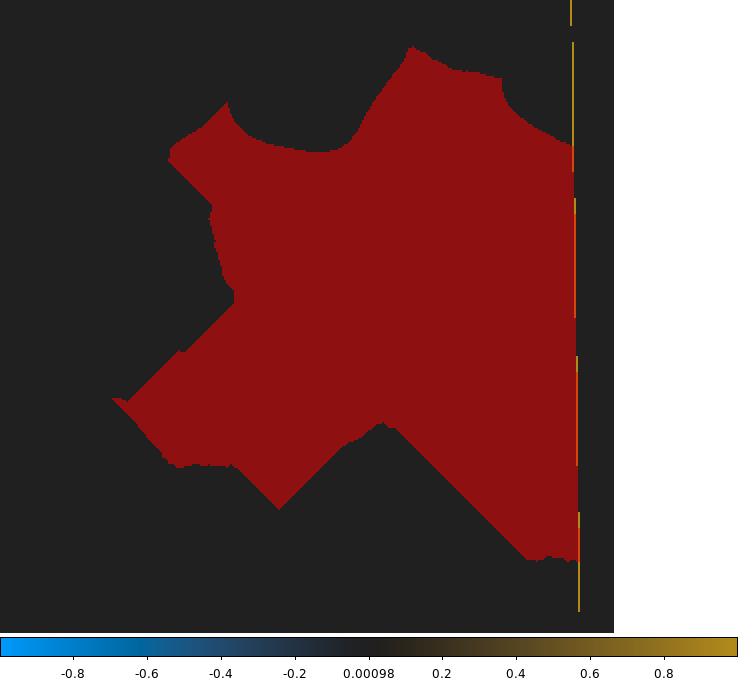

In [10]:
ds9 diff -block 1 -view panner no -view magnifier no -view info no \
  -scale limits -1 1 -zoom 2 \
  -cmap load diverging_bky_60-10_c30_n256.lut \
  -mask color red -mask transparency 50 -mask acisfJ0052448m263517_001N020_b_wavcell3.fits \
  -pan to 5873 4408 physical \
  -saveimage png ds9_04.png -quit

display < ds9_04.png

This shows that the wavdetect source _cell_ (red) hits the edge of the detector and specifically has pixels where the exposure map is non-zero, but the PSF_MAP is NaN (yellow).


## Connection to duplicate sources

My presumption is that there must have been a correlation maximum at the edge of the detector in one of those pixels where the exposure is non-zero by the PSF_SIZE was NaN.

Since the PSF_SIZE value is recorded for the location of the correlation maximum, the NaN at that location is presumably what was stored.

## Really?

Without the exactly wavdetect inputs needed to recreate the temporary correlation max lists as well, I cannot confirm that this truly really does explain the NaN values.

One hint that this is a valid explaination is to look at the input background map which has a depression at the edge.

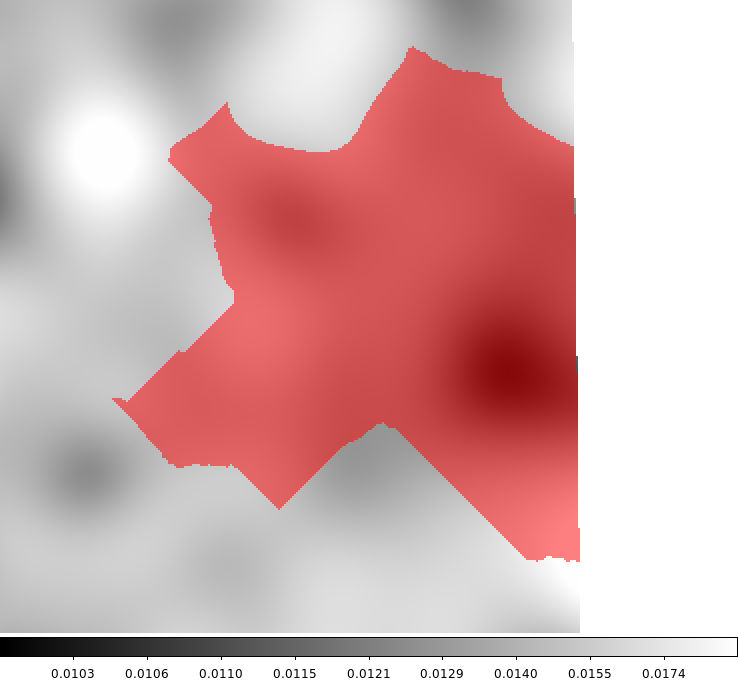

In [11]:
ds9 acisfJ0052448m263517_001N020_b_nbkg3.fits \
  -view panner no -view magnifier no -view info no \
  -scale limits 0.01 0.02 -scale asinh -zoom 2 \
  -mask color red -mask transparency 50 -mask acisfJ0052448m263517_001N020_b_wavcell3.fits \
  -pan to 5873 4408 physical \
  -saveimage png ds9_05.png -quit

display < ds9_05.png

Low backgorund, means higher positive correlation so likekly there is a  correlation max, at **some** wavelet scale, at/near that location.

## Pixel mask?

The pixel mask is interior to both the PSFMAP and the exposure map



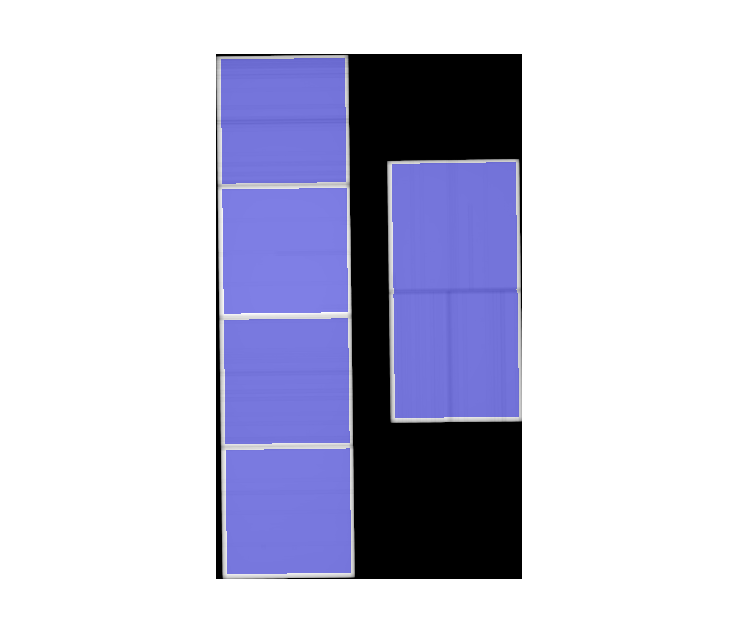

In [12]:
ds9 acisfJ0052448m263517_001N020_b_exp3.fits \
  -view panner no -view magnifier no -view info no -view colorbar no \
  -block 8 -scale log \
  -mask color mediumblue -mask transparency 50 -mask acisfJ0052448m263517_001N020_pixmask3.fits \
  -saveimage png ds9_06.png -quit

display < ds9_06.png

However, the correlation max are not filtered by the pixelmask.  Only final detect position.